In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
import seaborn as sns


from scipy.stats import binned_statistic
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d, CubicSpline
from scipy.optimize import curve_fit
import scipy

using vice version  1.4.0.dev2


In [3]:
import surp
from surp.analysis.vice_model import vice_model
import surp.analysis.apogee_analysis as aah
from surp.analysis import plotting_utils as pluto


import arya


In [4]:
df = aah.subgiants
filt = ~np.isnan(df["MG_H"])
filt &= ~np.isnan(df["C_MG"])
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["MG_FE_ERR"] + subgiants["N_FE_ERR"]
subgiants["C_N_ERR"] = subgiants["N_FE_ERR"] + subgiants["C_FE_ERR"]

In [5]:
def translate_label(s):
    return "[" + s.lower().replace("_", "/").replace("mg", "o") + "]"

In [6]:
def find_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the vice_model object
    """
    
    file_name = "../out/" + name
    return vice_model(file_name)


In [7]:
s0 = 5

    
def zoofe_data(y="C_MG", mg_0=-0.1, w=0.05, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    x, y, yerr = binned_stats(subgiants.MG_FE, subgiants[y], subgiants[y + "_ERR"], range=[-0.05, 0.35])
    
    plt.scatter(x, y, color="k", s=s0)
    plt.scatter(x, y-yerr, marker="_", color="k", alpha=0.3, s=s0)
    plt.scatter(x, y+yerr, marker="_", color="k", alpha=0.3, s=s0)

In [8]:
data_kwargs = dict(
    facecolor="k", 
    stat="median", errorbar="pi", 
    cap_kwargs=dict(facecolor="k", alpha=0.3)
)

model_kwargs = dict(
    facecolor="k", 
    stat="median", errorbar=None,
    aes="line"
)

def zooh_models(models, labels, y="C_MG", sequential=False):
    
    kwargs = dict(binrange=(-0.5, 0.5), binwidth=0.025)
    
    N = len(models)
    if sequential:
        hm = arya.figure.colorbar.HueMap(clim=(0, len(models)))
    for i in range(N):
        name = labels[i]
        model = models[i]
        if sequential:
            kwargs["color"] = hm(i)
        arya.binnedplot(model, x="[o/h]", y=translate_label(y), label=name, **model_kwargs, **kwargs)


    df = subgiants[~subgiants.high_alpha]
    
    arya.binnedplot(df, x="MG_H", y=y, zorder=-2, **data_kwargs, **kwargs)
    
    
def zoofe_models(models, labels, y="C_MG", sequential=False, mg_0=0.1, w=0.05):
    kwargs = dict(binrange=(-0.1, 0.5), binwidth=0.025)

    N = len(models)

    if sequential:
        hm = arya.figure.colorbar.HueMap(clim=(0, len(models)))
    for i in range(N):
        model = models[i]
        filt = model["[o/h]"] > mg_0 - w
        filt &= model["[o/h]"] < mg_0 + w
        df = model[filt]
        if sequential:
            kwargs["color"] = hm(i)
        arya.binnedplot(df, x="[o/fe]", y=translate_label(y), **model_kwargs, **kwargs)
    
    filt = subgiants["MG_H"] > mg_0 - w
    filt &= subgiants["MG_H"] < mg_0 + w
    df = subgiants[filt]

    arya.binnedplot(df, x="MG_FE", y=y, **data_kwargs, **kwargs)

In [9]:
def compare(names, labels, y = "C_MG", ylabel="[C/Mg]", filename=None, ylim=(-0.3, 0.1), **kwargs):
    models = [find_model(name).stars for name, label in zip(names, labels)]
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)
    plt.subplots_adjust(wspace=0)

    plt.sca(axs[0])
    zooh_models(models, labels, y=y, **kwargs)  

    plt.xlabel(f"[Mg/H]")
    plt.ylabel(ylabel)
    plt.xlim(-0.6, 0.6) 
    plt.ylim(ylim)
    plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4])
    arya.Legend(color_only=True)

    
    plt.sca(axs[1])
    zoofe_models(models, labels, y=y, **kwargs)
    
    
    plt.xlabel(r"[Mg/Fe]")
    plt.ylabel(r"")
    plt.xlim(-0.15, 0.4)
    plt.title("")
    
    if filename is not None:
        plt.savefig(filename)


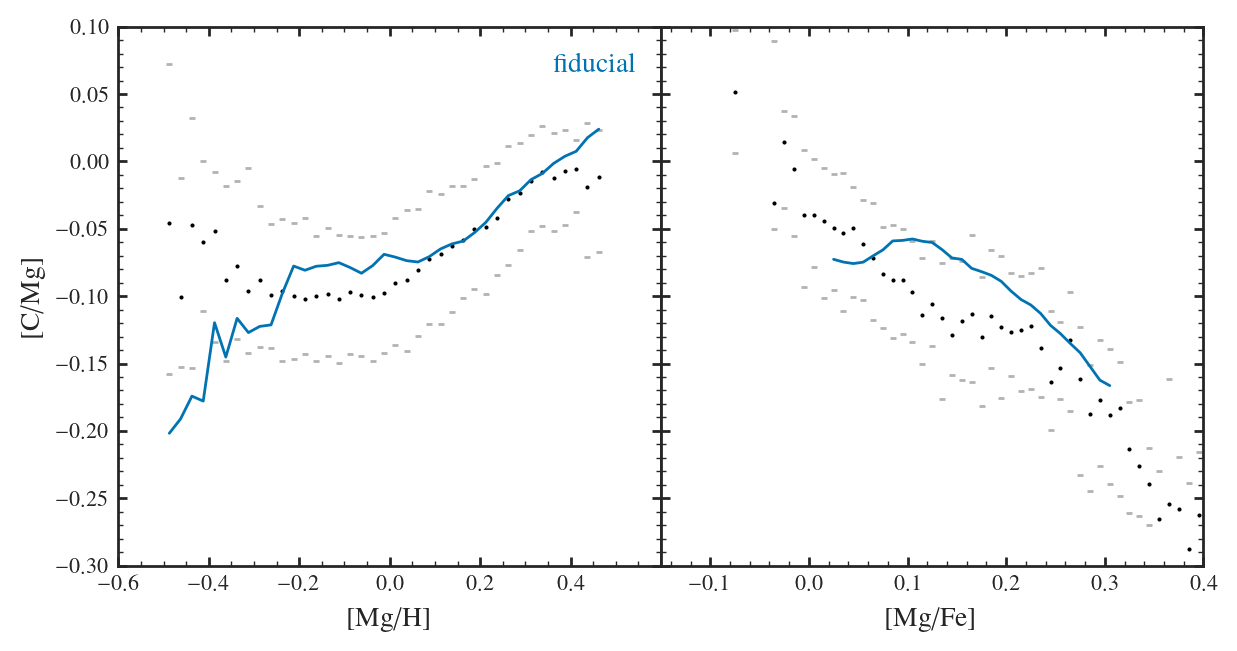

In [63]:
names = ["C11_f0.2_eta1_beta0.001.json"]
labels = ["fiducial", "gaussian migration", "multithreaded"]
compare(names, labels)

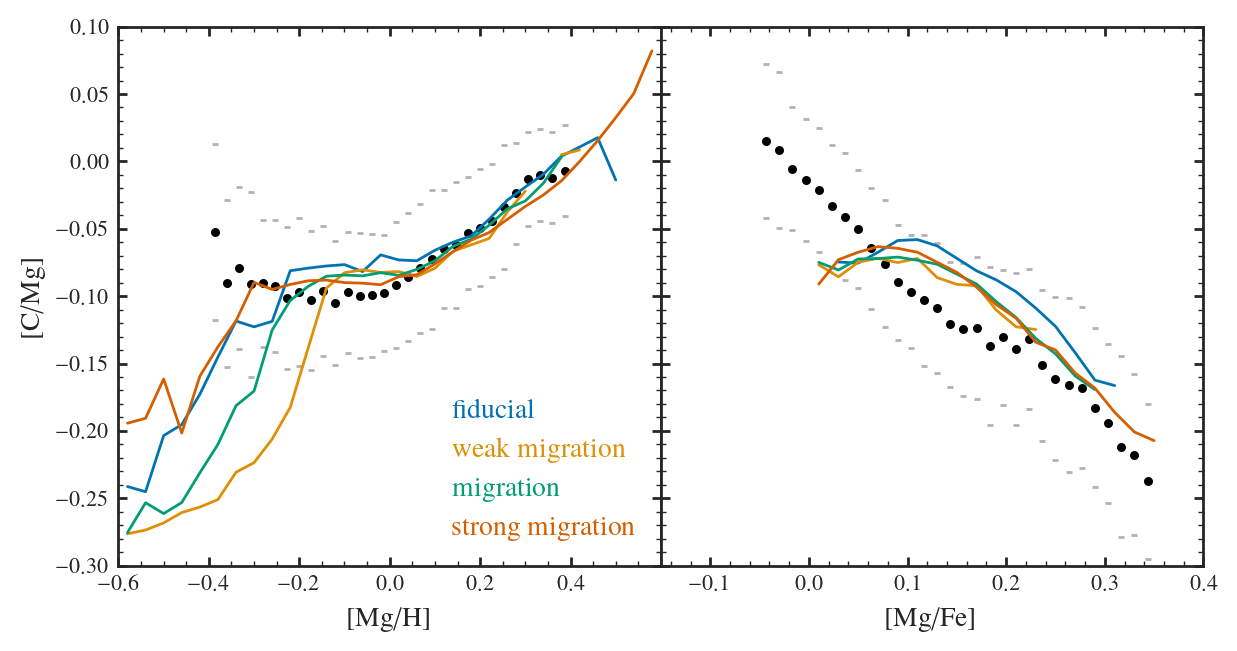

In [11]:
names = ["C11_f0.2_eta1_beta0.001.json", "C11_f0.2_beta0.001_rand_walk0.05_dt0.05.json", "C11_f0.2_beta0.001_rand_walk0.5_dt0.05.json", "C11_f0.2_beta0.001_rand_walk1.27_dt0.05.json"]

labels = ["fiducial", "weak migration", "migration", "strong migration"]
compare(names, labels, filename="migration_models.pdf")

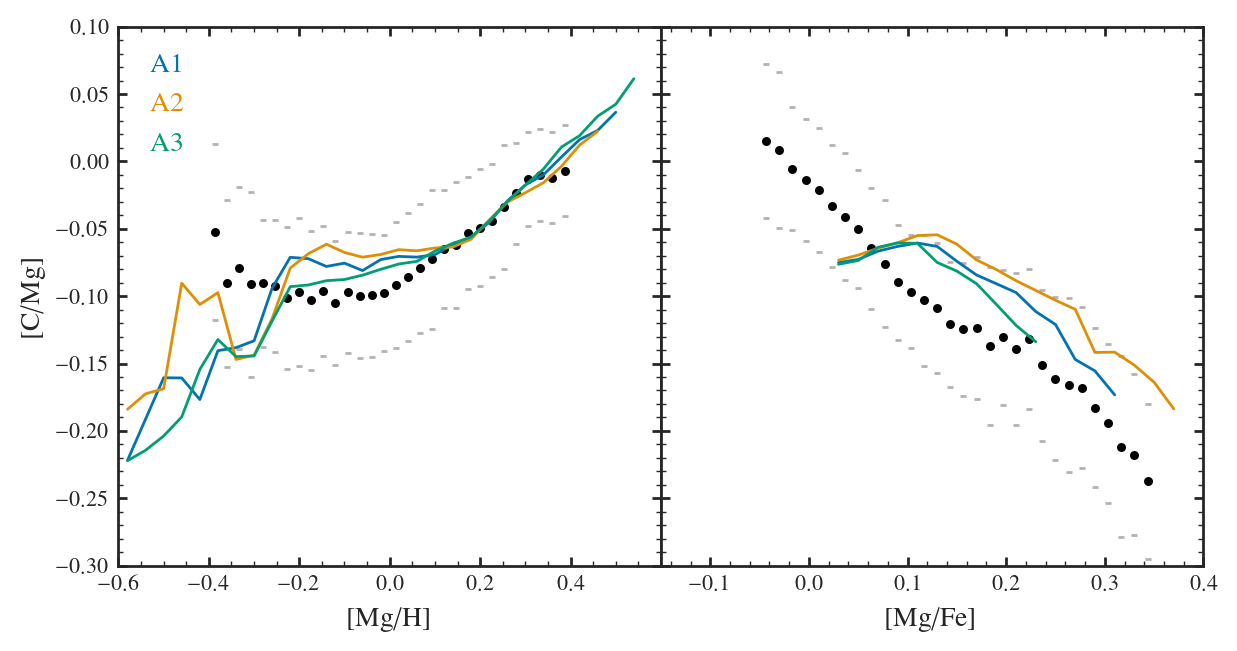

In [12]:
names = [
    "C11_f0.2_beta0.001.json",
    "C11_f0.24_beta0.001_Fe1.2.json",
    "C11_f0.16_beta0.001_Fe0.8.json",
]
compare(names, labels)

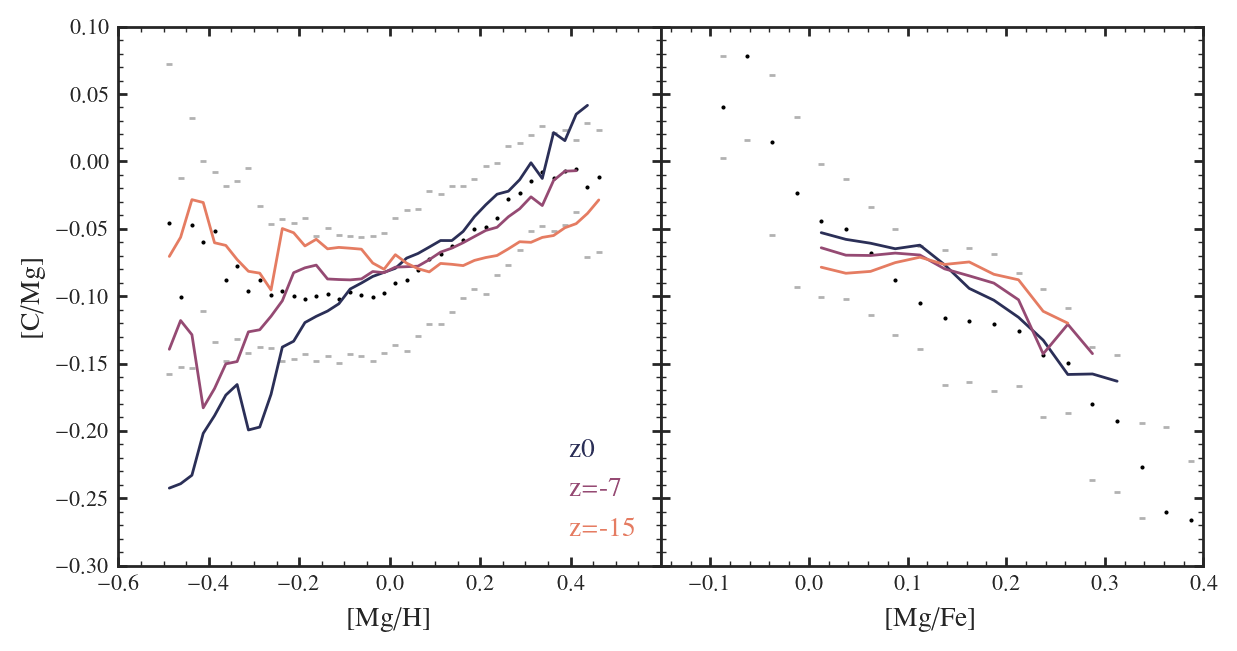

In [40]:
names = [
"A_1.3_2.3_4.3_z0_f0.2_beta0.001_dt0.05.json",
"A_1.3_2.3_4.3_z-7e-4_f0.2_beta0.001_dt0.05.json",
"A_1.3_2.3_4.3_z-15e-4_f0.2_beta0.001_dt0.05.json",
        ]

labels = ["z0", "z=-7", "z=-15", "A4", "A5"]
compare(names, labels, sequential=True, filename="agb_z_dependence.pdf")

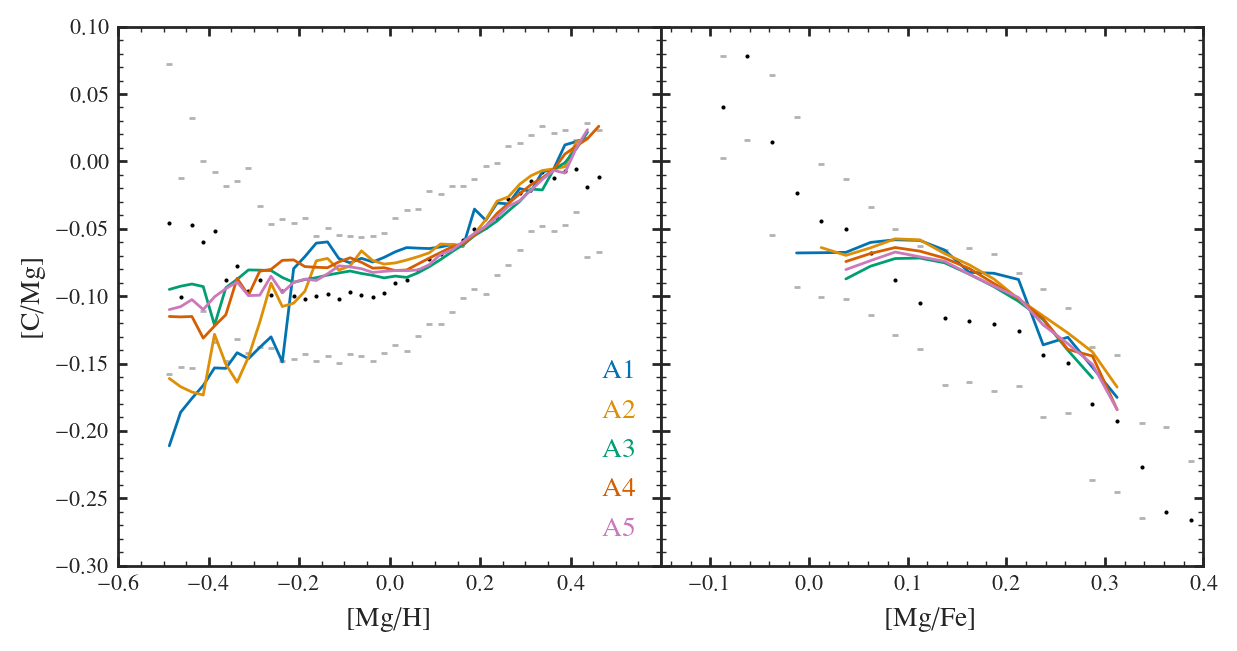

In [11]:
names = [
"C11_f0.2_beta0.001_dt0.1.json",
"C11_f0.2_beta0.001_dt0.02.json",
"C11_f0.2_beta0.001_post-process.json",
"C11_f0.2_beta0.001_linear.json",
"C11_f0.2_beta0.001_sudden.json",
        ]

labels = ["A1", "A2", "A3", "A4", "A5"]
compare(names, labels)

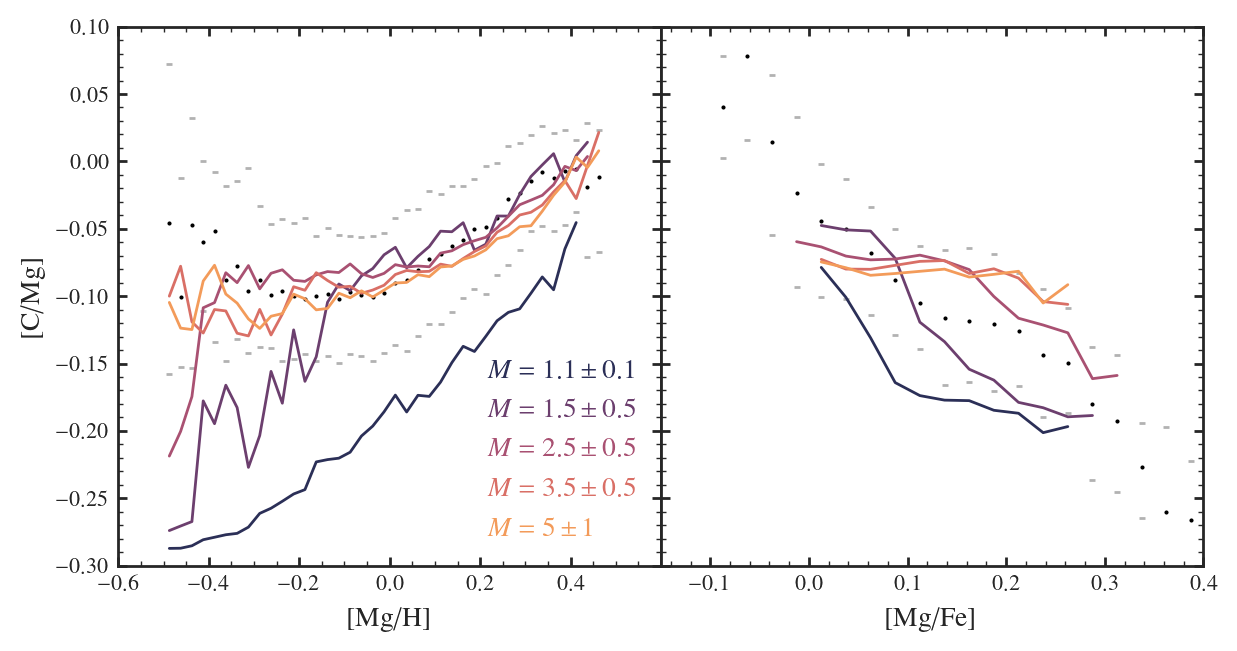

In [37]:
names = [
    "A_1_1.1_1.2_z-0.0007_f0.2_beta0.001_dt0.05.json",
        "A_1_1.5_2_z-0.0007_f0.2_beta0.001_dt0.05.json",
    "A_2_2.5_3_z-0.0007_f0.2_beta0.001_dt0.05.json",
"A_3_3.5_4_z-0.0007_f0.2_beta0.001_dt0.05.json",
"A_4_5_6_z-0.0007_f0.2_beta0.001_dt0.05.json",
        ]
labels = [r"$M = 1.1\pm 0.1$", 
          r"$M = 1.5\pm0.5$", 
          r"$M=2.5\pm0.5$", 
          r"$M=3.5\pm0.5$", 
          r"$M=5\pm1$"]
compare(names, labels, sequential=True, filename="agb_mass.pdf")

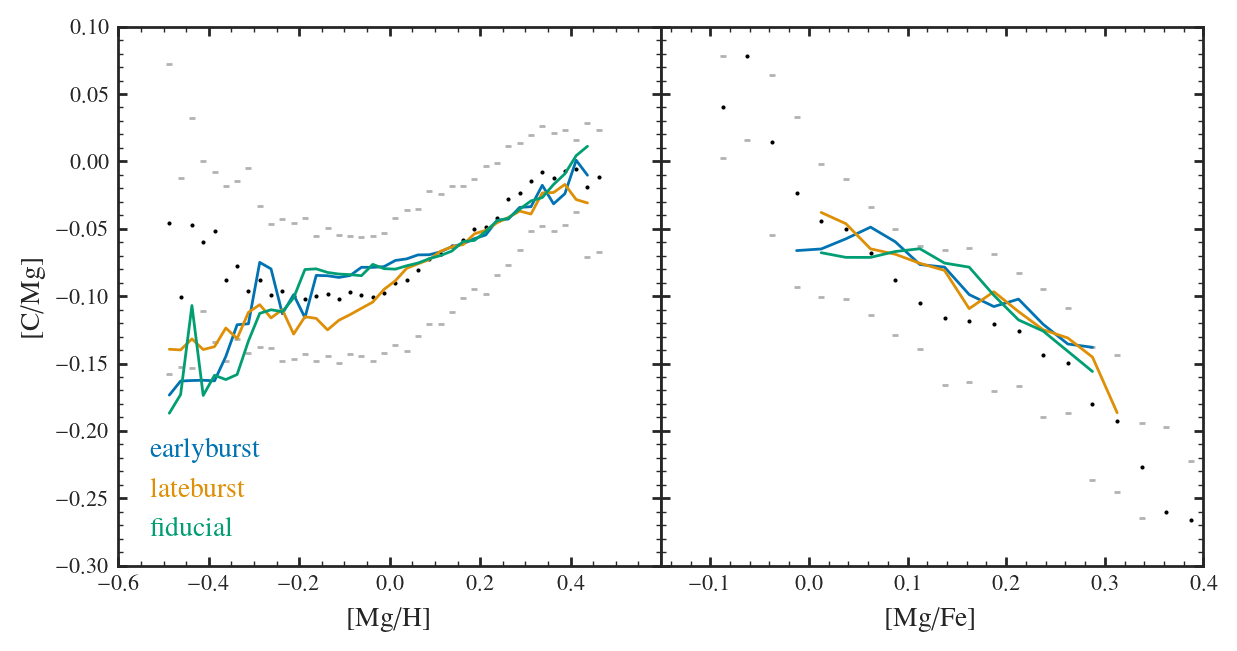

In [39]:
names = [
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_twoexp0.5_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_lateburst1.5_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_dt0.05.json",
]
labels = ["earlyburst", "lateburst", "fiducial", "A4", "A5"]
compare(names, labels)

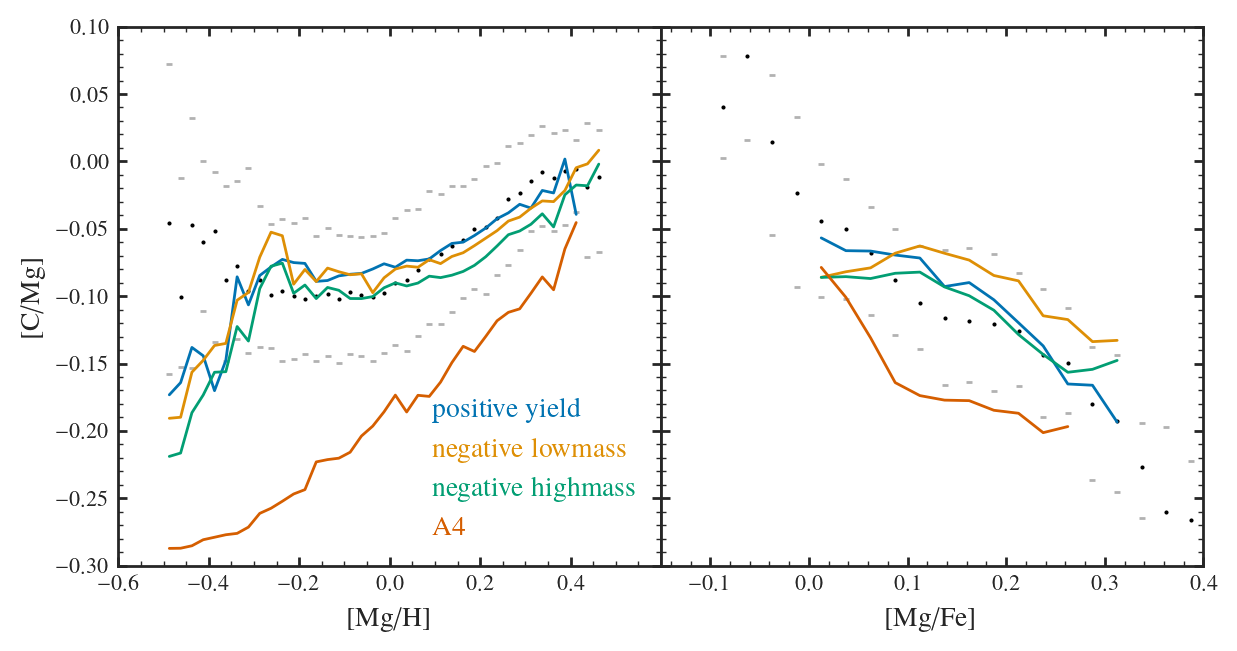

In [13]:
names = [
    "A_1_2_4_z-0.0007_f0.2_beta0.001_dt0.05.json",
    "A_1.3_2.3_4.3_z-0.0007_y0-1e-4_f0.2_beta0.001_dt0.05.json",
    "A_1.3_2.3_4.3_z-0.0007_y2-1e-4_f0.2_beta0.001_dt0.05.json",
    "A_1_1.1_1.2_z-0.0007_f0.2_beta0.001_dt0.05.json",
]

labels = ["positive yield", "negative lowmass", "negative highmass", "A4", "A5"]
compare(names, labels, filename="negative_yields.pdf")

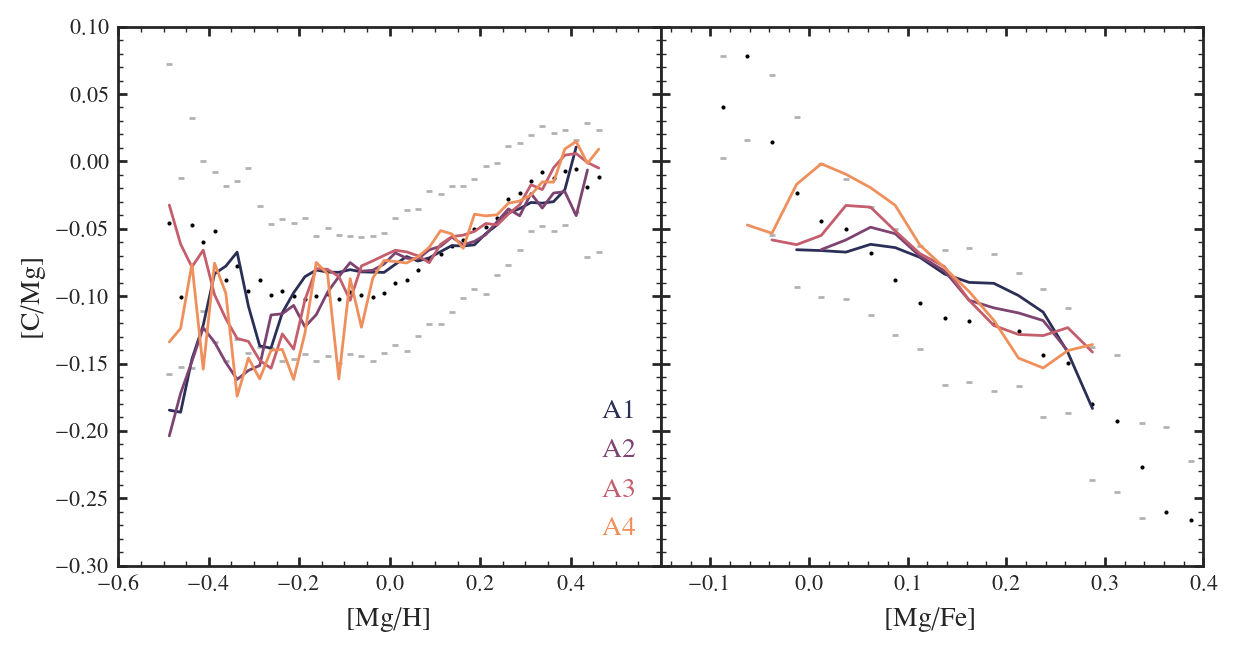

In [12]:
names = [
    "A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_twoexp0.25_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_twoexp0.5_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_twoexp1_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_twoexp2.0_dt0.05.json",
]

labels = ["A1", "A2", "A3", "A4", "A5"]
compare(names, labels, sequential=True, filename="twoexp_strength.pdf")

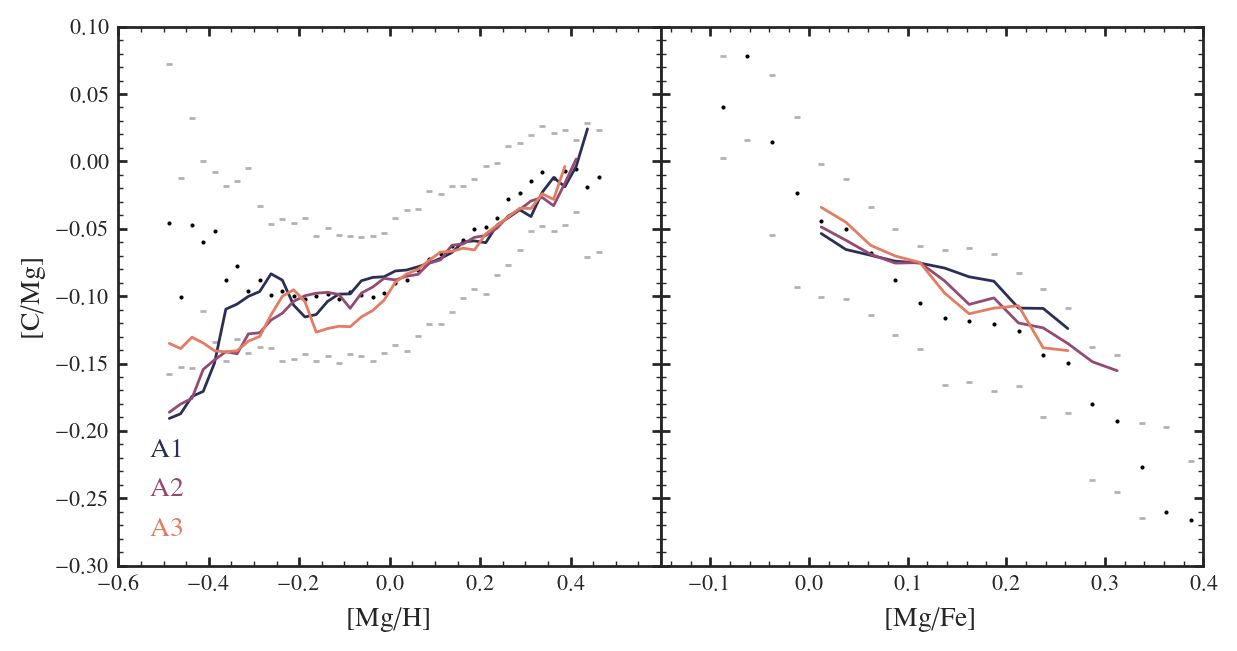

In [11]:
names = [
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_lateburst0.5_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_lateburst1.0_dt0.05.json",
"A_1.3_2.3_4.3_z-0.0007_f0.2_beta0.001_lateburst2.0_dt0.05.json",
]

labels = ["A1", "A2", "A3", "A4", "A5"]
compare(names, labels, sequential=True)

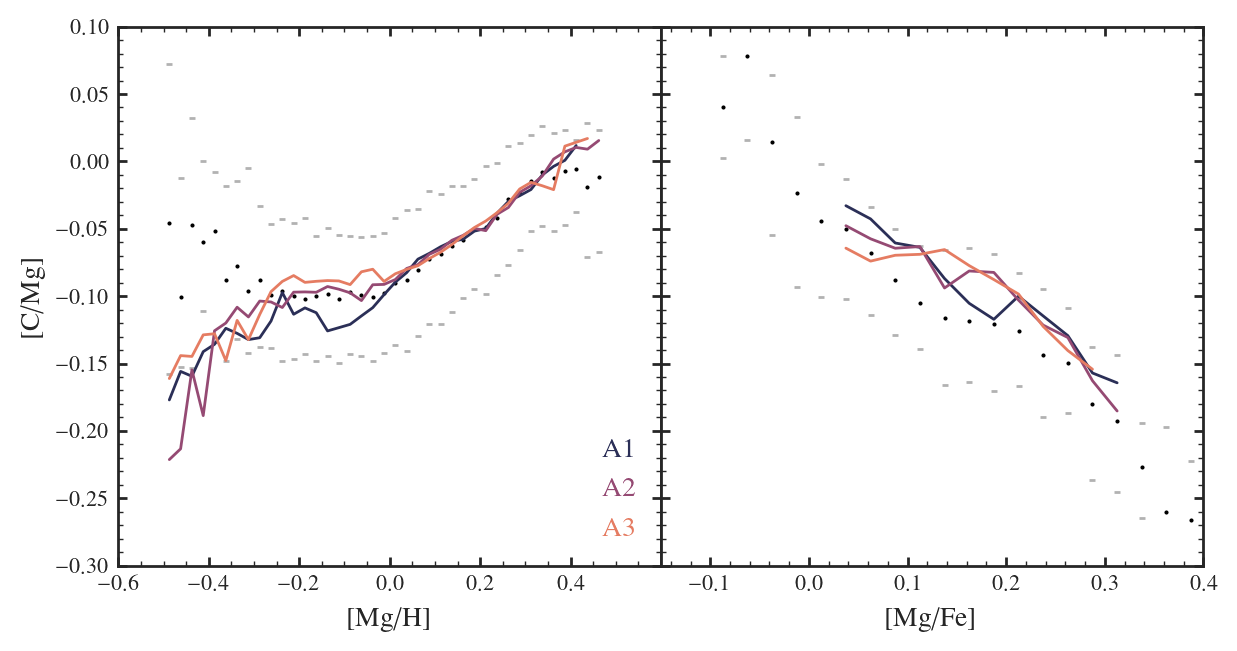

In [12]:
names = [
"C11_f0.2_beta0.001_lateburst2.0.json",
"C11_f0.2_beta0.001_lateburst1.0.json",
"C11_f0.2_beta0.001_lateburst0.5.json",
]

labels = ["A1", "A2", "A3", "A4", "A5"]
compare(names, labels, sequential=True)

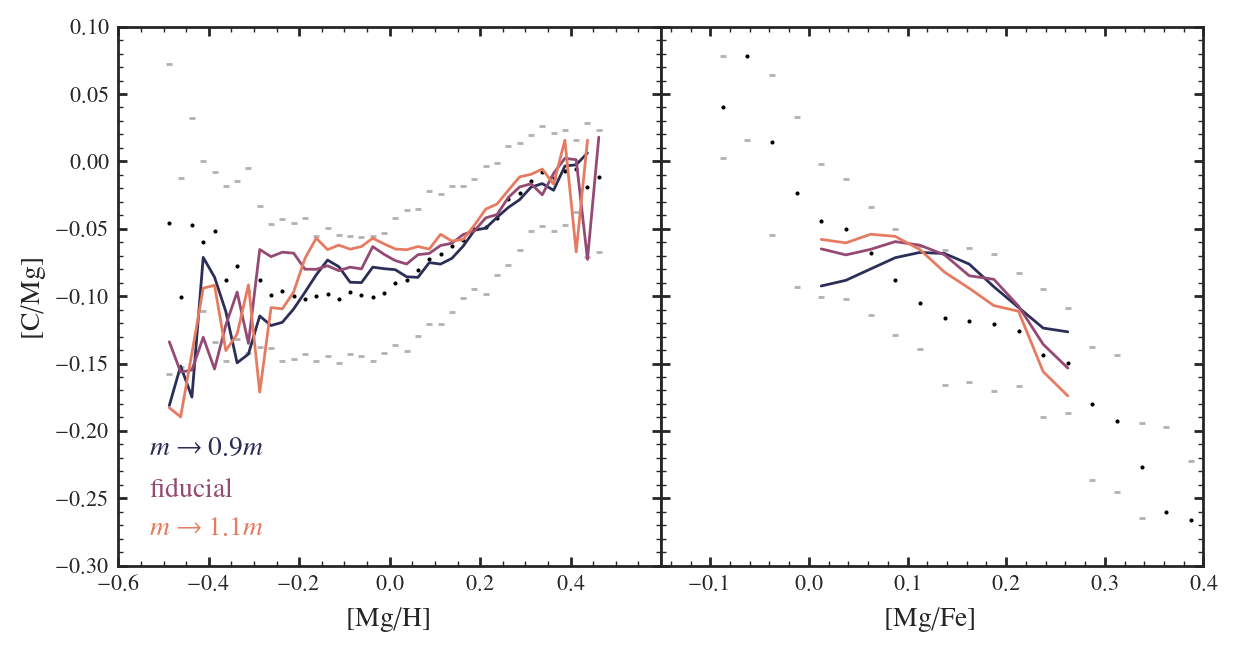

In [11]:
names = [
"C11_m0.9_f0.2_beta0.001_dt0.05_nthreads8.json",
"C11_f0.2_beta0.001_dt0.05_nthreads8.json",
"C11_m1.1_f0.2_beta0.001_dt0.05_nthreads8.json",
]

labels = [r"$m\to0.9m$", "fiducial", r"$m\to1.1m$", "A4", "A5"]
compare(names, labels, sequential=True, filename="shift_mass.pdf")

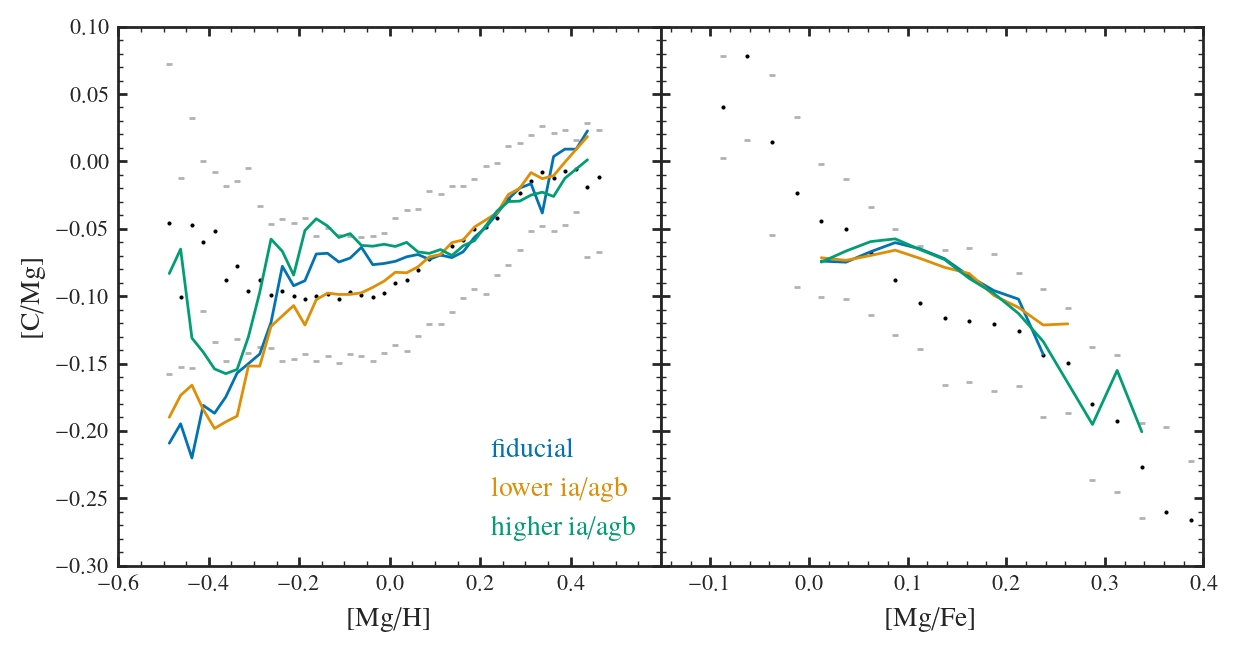

In [11]:
names = ["C11_f0.2_beta0.001_dt0.05.json",
"C11_f0.1_beta0.001_Fe0.9_dt0.05.json",
"C11_f0.3_beta0.001_Fe1.1_dt0.05.json",]

labels = [r"fiducial",
         "lower ia/agb",
         r"higher ia/agb"]
models = {label: find_model(name) for name, label in zip(names, labels)}
compare(names, labels, filename="ia_agb_degeneracy.pdf")

(-1.0, 0.5)

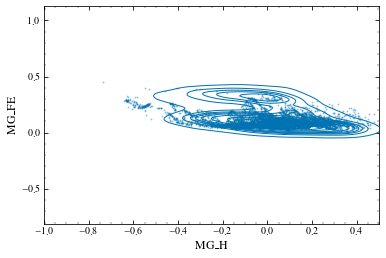

In [25]:
import seaborn as sns
df = find_model("C11_OOB_eta1_beta0.001")
plt.scatter(x=df["MG_H"], y=df["MG_FE"], s=1, alpha=0.3)
sns.kdeplot(x=subgiants.MG_H, y=subgiants.MG_FE);
plt.xlim(-1, 0.5)

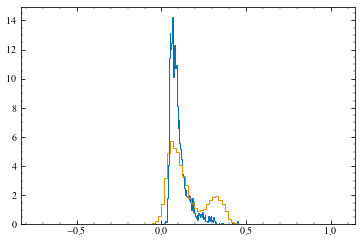

In [26]:
plt.hist(df["MG_FE"], 100, histtype="step", density=True)
plt.hist(subgiants["MG_FE"], 100, histtype="step", density=True);